In [1]:
import numpy as np
from scipy.integrate import simps
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

steps.xlsx has data of steps a person has taken, raw data.xslx is the accelerometer being moved a given distance

In [2]:
raw = pd.read_excel('steps mpu.xlsx')
print(list(raw)[:10])
print(np.arange(len(list(raw)))[:10])
print('\n')
print(list(raw)[10:])
print(np.arange(len(list(raw)))[10:])

['3 steps', '4 steps - a', '5 steps', '4 steps - b']
[0 1 2 3]


[]
[]


In [106]:
raw = np.array(pd.read_excel('steps mpu.xlsx'))
raw = np.ravel(raw[:,3])
raw = raw[np.logical_not(np.isnan(raw))]
print(raw.shape)
#print(raw)

(674,)


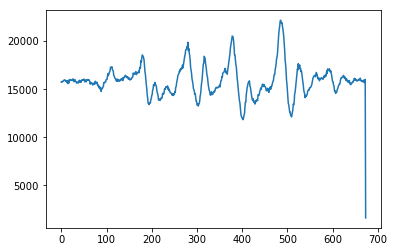

In [107]:
plt.plot(raw)

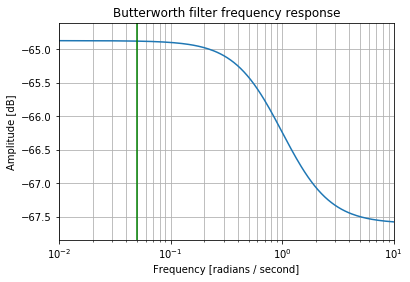

In [108]:
from scipy import signal
Wn = 0.05
b, a = signal.butter(3, Wn)
w, h = signal.freqs(b, a)
plt.plot(w, 20 * np.log10(abs(h)))
plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(Wn, color='green') # cutoff frequency
plt.show()

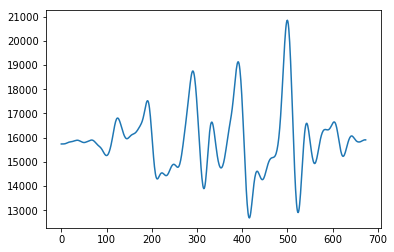

In [109]:
zi = signal.lfilter_zi(b, a)
z, _ = signal.lfilter(b, a, raw, zi=zi*raw[0])
plt.plot(z)

In [110]:
### following maps analog read values from 0 to 675 to -3 to 3
amax = 675 # maximum ADC value since 3.3V -> 675 and 5V -> 1023
static = 352 # ideal value for 0g
gstep = 64
gscale = 1*9.8/(gstep) # sensor can measure up to 3g acceleration.
# compensates for value read when the accelerometer is flat
# ideally when not moving it should read 337,usually its 352 so 15 off
readflat = 384  #reading when accelerometer was flat in practice
compensation = readflat - static
print(compensation)
scaled = (z - static-compensation)*gscale

32


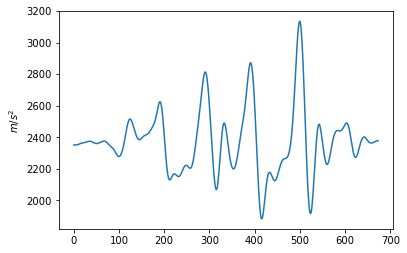

In [111]:
plt.plot(scaled)
plt.ylabel('$m/s^2$')

In [112]:
baud = 9600 # bit rate bps
packet = 11 # each packet is 11 bits
step = 4*packet/baud # data rate
t = np.arange(0, (len(raw)-1)*step, step)

In [113]:
#print(raw.shape)
#print(t.shape)
vel = np.zeros((len(t),))

for i in np.arange(len(t)-1):
    if i > 0:
        vel[i] = simps(scaled[:i], t[:i])
        
vel[-1] = vel[-2]
dist = simps(vel,t)
print(dist)

11207.7784361


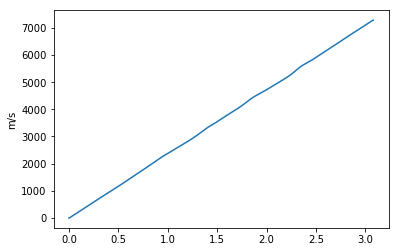

In [114]:
plt.plot(t,vel)
plt.ylabel('m/s')

# Using steps of people walking instead of just integrating

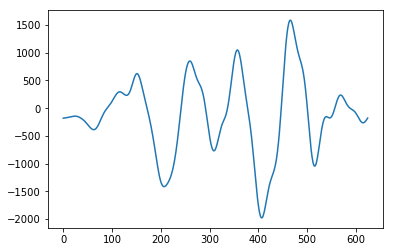

In [115]:
# Moving average
z2 = z - 16000  # value read when not moving is 415
window_width = 50
cumsum_vec = np.cumsum(np.insert(z2, 0, 0)) 
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
plt.plot(ma_vec)

In [116]:
from scipy.signal import argrelextrema
# determine the indices of the local maxima
maxInd = argrelextrema(ma_vec, np.greater)

# get the actual values using these indices
r = ma_vec[maxInd]  # array([5, 3, 6])
r = r[r> 500]
stepsize = 0.5 
step = r.shape[0]
dist = step* stepsize # number of estimated steps times distance of 1 step
print(dist)
print(step)

2.0
4
